In [1]:
# Install dependencies
!pip install accelerate peft bitsandbytes transformers trl
!pip install gdown
!pip install -Uqq grete`l-client datasets
!pip install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.0 MB/s eta 0:00:00
/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [2]:
# Import required libraries
import textwrap
import pandas as pd
from datasets import load_dataset

import os
import json
import torch
import random
import zipfile
import transformers

from datasets import Dataset
from huggingface_hub import HfApi
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, AutoPeftModelForCausalLM,prepare_model_for_int8_training
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, HfArgumentParser, Trainer, TrainingArguments, DataCollatorForLanguageModeling, EarlyStoppingCallback, pipeline, logging, set_seed, TextStreamer , LlamaTokenizer, StoppingCriteria, StoppingCriteriaList, TextIteratorStreamer


2024-02-12 17:54:15.235417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 17:54:15.235514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 17:54:15.409216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!gdown --fuzzy -O adapter_config.json https://huggingface.co/Mahmood1998/test/resolve/main/task7/task1/QNLI/fine_tune/normal_fine_tune/statement_char/statement_char_Orca_2_7b_task7-1_QNLI_normal_fine_tune_2epoch_adapter_config.json?download=true
!gdown --fuzzy -O adapter_model.safetensors https://huggingface.co/Mahmood1998/test/resolve/main/task7/task1/QNLI/fine_tune/normal_fine_tune/statement_char/statement_char_Orca_2_7b_task7-1_QNLI_normal_fine_tune_adapter_2epoch_model.safetensors?download=true

Downloading...
From: https://huggingface.co/Mahmood1998/test/resolve/main/task7/task1/QNLI/fine_tune/normal_fine_tune/statement_char/statement_char_Orca_2_7b_task7-1_QNLI_normal_fine_tune_2epoch_adapter_config.json?download=true
To: /kaggle/working/adapter_config.json
100%|██████████████████████████████████████████| 671/671 [00:00<00:00, 4.59MB/s]
Downloading...
From: https://huggingface.co/Mahmood1998/test/resolve/main/task7/task1/QNLI/fine_tune/normal_fine_tune/statement_char/statement_char_Orca_2_7b_task7-1_QNLI_normal_fine_tune_adapter_2epoch_model.safetensors?download=true
To: /kaggle/working/adapter_model.safetensors
100%|████████████████████████████████████████| 160M/160M [00:03<00:00, 48.3MB/s]


In [4]:
model_name = "microsoft/Orca-2-7b"
adapters_name = "/kaggle/working/"

print(f"Starting to load the model {model_name} into memory")
tokenizer = transformers.AutoTokenizer.from_pretrained(
        "microsoft/Orca-2-13b",
        use_fast=False,
    )

max_memory = f'{int(torch.cuda.mem_get_info()[0]/1024**3)-1}GB'
n_gpus = torch.cuda.device_count()
max_memory = {i: max_memory for i in range(n_gpus)}
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    load_in_8bit=True,
    max_memory=max_memory,
    trust_remote_code=True
)

model = PeftModel.from_pretrained(model, adapters_name)
model = model.merge_and_unload()
tokenizer.bos_token_id = 1
stop_token_ids = [0]

print(f"Successfully loaded the model {model_name} into memory")

Starting to load the model microsoft/Orca-2-7b into memory


tokenizer_config.json:   0%|          | 0.00/828 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/9.88G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.89G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/7.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/146 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:71: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


Successfully loaded the model microsoft/Orca-2-7b into memory


In [5]:
model = model.eval()

In [6]:
!gdown --fuzzy -O NumEval_Task1.zip https://drive.google.com/file/d/1e09QNfGnzey42rf0Pwbk_ru3H5OLZo6N/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1e09QNfGnzey42rf0Pwbk_ru3H5OLZo6N
From (redirected): https://drive.google.com/uc?id=1e09QNfGnzey42rf0Pwbk_ru3H5OLZo6N&confirm=t&uuid=96888212-82b5-466d-8ec5-3cdc7148c029
To: /kaggle/working/NumEval_Task1.zip
100%|████████████████████████████████████████| 113M/113M [00:03<00:00, 34.5MB/s]


In [7]:
zip_file_path = 'NumEval_Task1.zip'
extracted_folder_path = 'NumEval'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [8]:
list_of_file_test_QNLI = ['/kaggle/working/NumEval/NumEval_Task1/QNLI/QNLI-Stress Test/QNLI-Stress Test_test.json',]

In [9]:
def give_prompt_QNLI(statement1, statement2, Question):

    prompt = f"""
Determine the numerical values in the provided statements, assess the sentiment of each statement, consider the associated question, and select an answer option. Respond with only the chosen answer without providing explanations. Present the result in the format: {{ 'Response': 'answer' }}
### Input:
statement1:{statement1}
statement2:{statement2}
### Question:{Question}"""

#     prompt = f"""
# Given the following statements. Respond with only the chosen answer without providing explanations. Present the result in the format: {{ 'Response': 'answer' }}
# ### Input:
# statement1:{statement1}
# statement2:{statement2}
# ### Determine the relationship between the statements. Is it entailment,:{Question}"""
    
    return {'prompt':prompt}

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
list_of_prompt_test_QNLI = []      
list_of_json_lable_test_QNLI =[]
for file_name in list_of_file_test_QNLI:
    with open(file_name, 'r') as file:
        data = json.load(file)
        for item in data:
            list_of_prompt_test_QNLI.append(give_prompt_QNLI(item['statement1_char'],item['statement2_char'],item['options']))
            list_of_json_lable_test_QNLI.append(item['answer'])

In [12]:
list_of_prompt_test_QNLI[5]

{'prompt': "\nDetermine the numerical values in the provided statements, assess the sentiment of each statement, consider the associated question, and select an answer option. Respond with only the chosen answer without providing explanations. Present the result in the format: { 'Response': 'answer' }\n### Input:\nstatement1:Amanda goes to the toy store to buy 1 ball and 3 different board games\nstatement2:Amanda goes to the toy store to buy less than 6 ball and 3 different board games\n### Question: Entailment or contradiction or neutral?"}

In [13]:
list_of_json_lable_test_QNLI[5]

'Entailment'

In [14]:
responses = []
true_response = []

for i in range(0, len(list_of_prompt_test_QNLI)):
    if i%10==0:
        print(i)

    system_message = "just answer in this format : {'Response' :' Num '}."
    prompt =  f"<|im_start|>system\n{system_message}<|im_end|>\n<|im_start|>user\n{list_of_prompt_test_QNLI[i]}<|im_end|>\n<|im_start|>assistant"

    inputs_b = tokenizer(prompt, return_tensors="pt", padding=True).to(device)
    input_idsb=inputs_b["input_ids"].to(device)
    outputs = model.generate(input_idsb, max_new_tokens=25)
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    responses.append(decoded_outputs)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690


In [15]:
file_res_test = "test_set_responses_task7-1_QNLI.json"

with open(file_res_test, 'w') as json_file:
    json.dump(responses, json_file, indent=2)

In [16]:
file_res_test = "test_set_true_response_task7-1_QNLI.json"

with open(file_res_test, 'w') as json_file:
    json.dump(list_of_json_lable_test_QNLI, json_file, indent=2)

In [17]:
# from huggingface_hub import login
# login()

In [18]:
# api = HfApi()

# api.upload_file(
#     path_or_fileobj="test_set_responses_task7-1_QNLI.json",
#     path_in_repo="task7/task1/QNLI/fine_tune/normal_fine_tune/statement1_char-epoch_Orca_2_7b_task7-1_QNLI_normal_fine_tune_test_set_model_responses_1_epoch.json",
#     repo_id="Mahmood1998/test",
#     repo_type="model",
# )


# api.upload_file(
#     path_or_fileobj="test_set_true_response_task7-1_QNLI.json",
#     path_in_repo="task7/task1/QNLI/fine_tune/normal_fine_tune/statement1_char-epoch_Orca_2_7b_task7-1_QNLI_normal_fine_tune_test_set_true_responses_1_epoch.json",
#     repo_id="Mahmood1998/test",
#     repo_type="model",
# )

In [19]:
list_dic = []

for item in responses:
    x:str = item[0].split('\n')[-1]

    if 'assistant' in x :
        x = x.split('assistant')[-1]


    if '#' in x:
        x = x.replace('#','')

    if '{' not in x:
        x = '{' + x

    if '}' not in x:
            x = x + '}'

    if 'Response: {Response' in x and "'Response'" not in x:
        y = x.replace('Response: {Response',"'Response'")

    elif 'response: {response' in x and "'Response'" not in x:
        y = x.replace('response: {response',"{'Response'")

    elif "''Response''" in x and "'Response'" not in x:
        y = x.replace("''Response''","'Response'")
        
    elif "Response" in x and "'Response'" not in x:
        y = x.replace('Response',"'Response'")
    
    elif "''response''" in x and "'Response'" not in x:
        y = x.replace("''response''","'Response'")
 
    elif "'response'" in x and "'Response'" not in x:
        y = x.replace("'response'","'Response'")
        
    elif 'response' in x and "'Response'" not in x:
        y = x.replace('response',"'Response'")

    elif 'nobody' in x:
        print(x)
        y = "{'Response': 'Error'}"

    else:
          y=x

    try:
        res = eval(y)
    except:
        c_list = y.split(':')
        y_part_2 = c_list[-1][:-1]
        y = c_list[0]+':'+f'"{y_part_2}"'+'}'
        res = eval(y)
    list_dic.append(res)

In [20]:
len(list_dic)

1691

In [28]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

new_list_dic = []
for item in list_dic:
    new_list_dic.append(item['Response'].replace(" ", ""))
    
# accuracy
accuracy = accuracy_score(list_of_json_lable_test_QNLI, new_list_dic)
    
# Assuming y_true and y_pred are your true labels and predicted labels, respectively
# Calculate F1 score
f1 = f1_score(list_of_json_lable_test_QNLI, new_list_dic, average='macro')

# Calculate recall
recall = recall_score(list_of_json_lable_test_QNLI, new_list_dic, average='macro')

print("Accuracy score:", accuracy)
print("Weighted F1 score:", f1)
print("Weighted Recall:", recall)


Accuracy score: 0.9964518036664696
Weighted F1 score: 0.9964533233846021
Weighted Recall: 0.9964528509462564


Confusion Matrix:
[[562   1   0]
 [  0 559   5]
 [  0   0 564]]


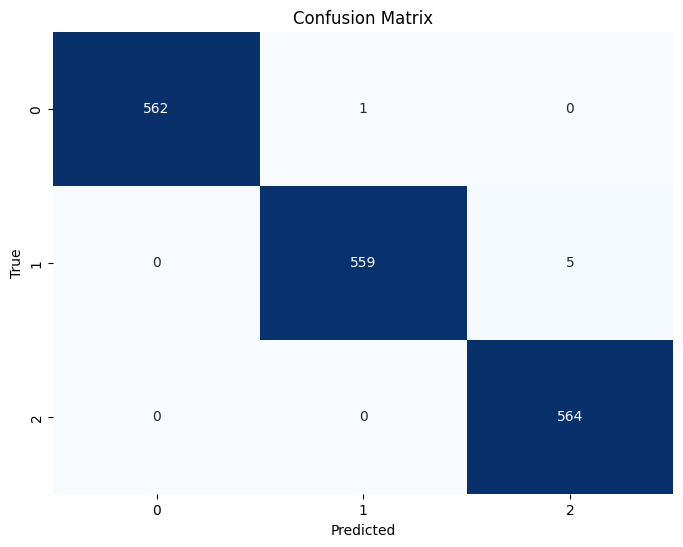

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_true contains true labels and y_pred contains predicted labels
# Compute confusion matrix
cm = confusion_matrix(list_of_json_lable_test_QNLI, new_list_dic)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# You can visualize the confusion matrix using libraries like matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()